In [1]:
!pip install transformers

# 1. Load Dataset

In [2]:
# Step 1: Load the dataset
from google.colab import files
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Mengunggah file secara manual
uploaded = files.upload()

# Membaca dataset (sesuaikan dengan nama file yang diunggah)
filename = list(uploaded.keys())[0]  # Ambil nama file pertama yang diunggah
df = pd.read_csv(filename)

# Dimensi dataset
df.shape

Saving fix_clickbait_data.csv to fix_clickbait_data.csv


(1000, 2)

In [3]:
df.sample(5)

,headline,clickbait
391,A Gorilla Looked On As A Guy Went Through Pics...,1
52,What Is Your Favorite Activity When Visiting F...,1
566,Local Agencies Team Up to Sell Industry on Min...,0
743,US Secret Service officer arrested during pros...,0
306,"The Cast Of ""Gilmore Girls"" In Their First Epi...",1


Text(0, 0.5, 'samples')

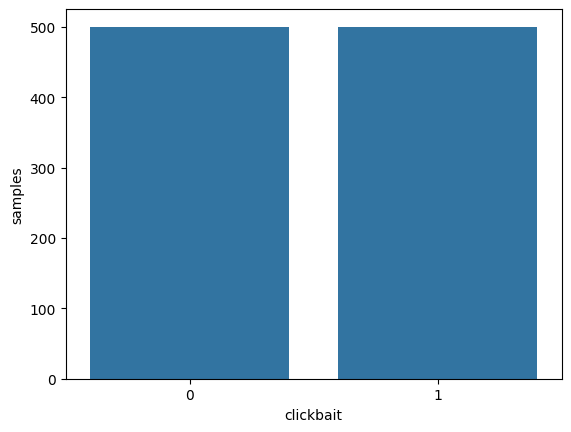

In [4]:
# Visualisasi Data
import seaborn as sns
import matplotlib.pyplot as plt

x = df.clickbait.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('samples')

# 2. Load BERT Tokenizer

In [5]:
sentences = df.headline.values
labels = df.clickbait.values

In [6]:
# Step 2: Load BERT Tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Contoh Tokenisasi
print('Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token Ids: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Should I Get Bings
Tokenized:  ['should', 'i', 'get', 'bing', '##s']
Token Ids:  [2323, 1045, 2131, 17620, 2015]


In [8]:
# Menyimpan token ID dari setiap kalimat
input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens=True,
        )
    input_ids.append(encoded_sent)

# contoh kalimat di dataset yang telah ditokenisasi
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Should I Get Bings
Token IDs: [101, 2323, 1045, 2131, 17620, 2015, 102]


In [9]:
# Melihat token yang paling panjang
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  28


In [10]:
# Menambahkan padding dan truncating agar panjang setiap kalimat sama
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 28

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")


Padding/truncating all sentences to 28 values...

Padding token: "[PAD]", ID: 0


In [11]:
# contoh input_ids setelah ditambahkan padding
input_ids[0]

array([  101,  2323,  1045,  2131, 17620,  2015,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [12]:
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [13]:
#contoh atention_mask
attention_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# 3. Persiapkan Data
### Membagi Dataset menjadi Train, Validation, dan Test



In [14]:
# Step 3: Persiapkan Data
# Membagi dataset menjadi subset yang akan digunakan dalam pelatihan, validasi, dan pengujian model.
from sklearn.model_selection import train_test_split

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=2017, test_size=0.1)

train_masks, test_masks, _, _ = train_test_split(attention_masks, labels, random_state=2017, test_size=0.1)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, random_state=2018, test_size=0.15)

train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks, random_state=2018, test_size=0.15)

In [15]:
# Kesimpulan pembagian data
import numpy as np

print("== Train ==")
print("Input: ", train_inputs.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_masks).shape)

print("\n== Validation ==")
print("Input: ", validation_inputs.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_masks).shape)

print("\n== Test ==")
print("Input: ", test_inputs.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_masks).shape)

== Train ==
Input:  (765, 28)
Label:  (765,)
Mask:  (765, 28)

== Validation ==
Input:  (135, 28)
Label:  (135,)
Mask:  (135, 28)

== Test ==
Input:  (100, 28)
Label:  (100,)
Mask:  (100, 28)


In [16]:
# Mengubah data menjadi Pytorch tensor
import torch

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)

In [17]:
train_inputs[0]

tensor([  101,  2017,  1005,  2222,  2022,  1999,  4000,  2044,  4994,  6498,
        24665, 16429,  2319,  1998,  5163, 18648, 11979,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [18]:
# Membuat dataloader untuk dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32 # ukuran data dalam satu batch

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 4. Persiapkan Model Pre-trained BERT

In [19]:
# Step 4: Persiapkan model pre-trained BERT
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False, # Tidak menyimpan hasil self-attention (tidak diperlukan untuk klasifikasi)
    output_hidden_states = False, #  Tidak menyimpan seluruh hidden states BERT (hanya output akhir yang digunakan).
)

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
# Menampilkan parameter-parameter dalam model BERT
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                       (30522, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
ber

In [21]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

In [22]:
# Mengatur learning rate (scheduler)
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Tidak ada warmup (learning rate langsung aktif penuh)
                                            num_training_steps = total_steps) # Jumlah total langkah training

In [23]:
# Fungsi untuk menghitung akurasi model
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
# Cek device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


# 5. Training BERT

In [26]:
# Step 5: Training BERT
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    #=======================================
    #               Training
    #=======================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    model.train()

    # Foreach batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches
        if step % (len(train_dataloader) // 5) == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # Training
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # nilai loss
        loss = outputs[0] # Loss function yang digunakan (BCE)
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Mencegah exploding gradient.
        optimizer.step() # Bobot diperbarui menggunakan AdamW optimizer.
        scheduler.step() # Learning rate dikurangi sesuai jadwal (linear decay).

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    #========================================
    #               Validation
    #========================================

    print("Running Validation...")

    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch     4  of     24.    Elapsed: 0:00:02.
  Batch     8  of     24.    Elapsed: 0:00:02.
  Batch    12  of     24.    Elapsed: 0:00:03.
  Batch    16  of     24.    Elapsed: 0:00:04.
  Batch    20  of     24.    Elapsed: 0:00:04.

  Average training loss: 0.44
  Training epcoh took: 0:00:05
Running Validation...
  Accuracy: 0.96
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch     4  of     24.    Elapsed: 0:00:01.
  Batch     8  of     24.    Elapsed: 0:00:01.
  Batch    12  of     24.    Elapsed: 0:00:02.
  Batch    16  of     24.    Elapsed: 0:00:03.
  Batch    20  of     24.    Elapsed: 0:00:03.

  Average training loss: 0.11
  Training epcoh took: 0:00:04
Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...
  Batch     4  of     24.    Elapsed: 0:00:01.
  Batch     8  of     24.    Elapsed: 0:00:01.
  Batch    12  of     24.    Elapsed: 0:00:02.
  Ba

# 6. Prediksi dan Evaluasi

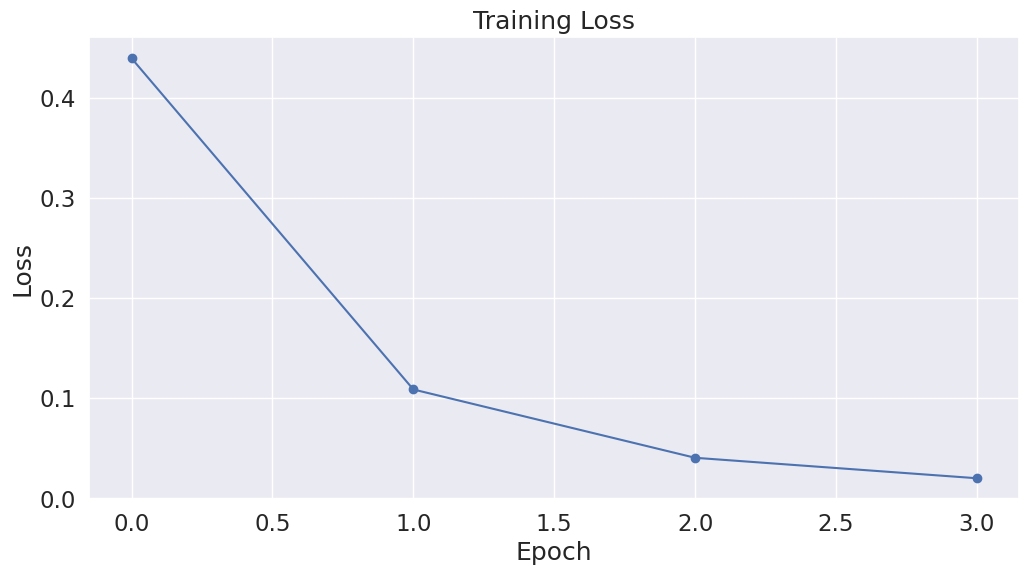

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [28]:
# Step 6: Predic and Evaluate
print("Predicting labels for {:,} test sentences".format(len(test_inputs)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 100 test sentences
 DONE.


In [29]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("Matthew's Correlation Coefficient (MCC): %.3f" %mcc)

Matthew's Correlation Coefficient (MCC): 0.961


In [30]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.980


In [31]:
from sklearn.metrics import classification_report

# Hitung laporan klasifikasi
report = classification_report(flat_true_labels, flat_prediction, target_names=["Not Clickbait", "Clickbait"])

# Cetak hasilnya
print(report)

               precision    recall  f1-score   support

Not Clickbait       0.96      1.00      0.98        53
    Clickbait       1.00      0.96      0.98        47

     accuracy                           0.98       100
    macro avg       0.98      0.98      0.98       100
 weighted avg       0.98      0.98      0.98       100



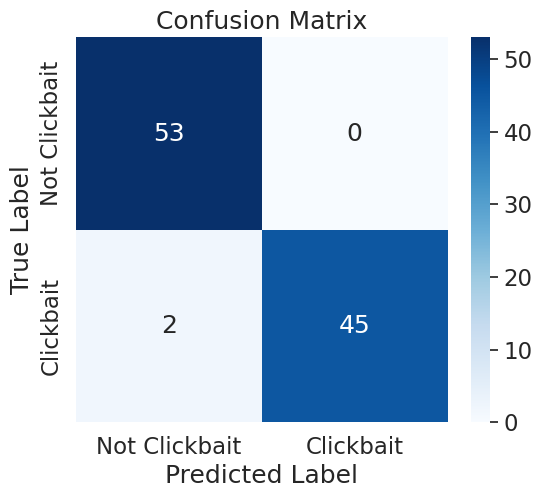

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(flat_true_labels, flat_prediction)

# Buat plot heatmap confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Clickbait", "Clickbait"], yticklabels=["Not Clickbait", "Clickbait"])

# Tambahkan label
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Uji Coba

In [ ]:
text = input("Masukkan judul berita: ")

encoded_text = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**encoded_text)

logits = outputs.logits
prediction = torch.argmax(logits, dim=1).item()

if prediction == 1:
    print("Judul ini kemungkinan *clickbait*!")
else:
    print("Judul ini bukan *clickbait*.")